At the end of the experiment:

1. Understand how to deal with the text preprocessing
2. Perform dimensionality reduction using an Autoencoder for text
3. Create effective semantic representations of variable sized text




### Description

This dataset is a collection of approximately 20,000 newsgroup documents, partitioned nearly evenly across 20 different newsgroups. That is there are approximately one thousand documents taken from each of the following newsgroups:

    alt.athesim
    comp.graphics   
    comp.os.ms-windows.misc
    comp.sys.ibm.pc.hardware
    comp.sys.mac.hardware
    comp.windows.x
    misc.forsale
    rec.autos
    rec.motorcycles
    rec.sport.baseball
    rec.sport.hockey
    sci.crypt
    sci.electronics
    sci.med
    sci.space
    soc.religion.christian
    talk.politics.guns
    talk.politics.mideast
    talk.politics.misc
    talk.religion.misc

The dataset consists **Usenet** posts--essentially an email sent by someone to that newsgroup. They typically contain quotes from previous posts as well as cross posts; that is a few posts may be sent to more than one newsgroup.

Each newsgroup is stored in a subdirectory, with each post stored as a separate file.

Data source to this experiment : http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

#### Importing required packages

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
### importing pytorch packages
import torch
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch import nn
import torch.autograd as autograd
from sklearn import manifold

In [ ]:
ls

028_Autoencoder_Word2vec_text_C.ipynb
AIML_DS_GOOGLENEWS-VECTORS-NEGATIVE-300_STD.bin
AIML_DS_NEWSGROUPS_PICKELFILE.pkl
AIML_DS_NEWSGROUPS_PICKELFILE.pkl.zip
sample_data/


#### Loading the dataset

In [ ]:
import pickle
dataset = pickle.load(open("AIML_DS_NEWSGROUPS_PICKELFILE.pkl",'rb'))
print(dataset.keys())

dict_keys(['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc'])


In [ ]:
train_set = {}
test_set = {}

# Clean dataset for text encoding issues :- Very useful when dealing with non-unicode characters
for key in dataset:
    dataset[key] = [[i.decode('utf-8', errors='replace').lower() for i in f] for f in dataset[key]]
    
# Break dataset into 95-5 split for training and testing
n_train = 0
n_test = 0
for k in dataset:
    split = int(0.95*len(dataset[k]))
    train_set[k] = dataset[k][0:split]
    test_set[k] = dataset[k][split:-1]
    n_train += len(train_set[k])
    n_test += len(test_set[k])

#### Calculating the frequency of the words

In [ ]:
import collections
import re
import operator
frequency = collections.defaultdict(int)
    
for key in train_set:
    for f in train_set[key]:
        
        # Find all words which consist only of capital and lowercase characters and are between length of 2-9.
        # We ignore all special characters such as !.$ and words containing numbers
        words = re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', ' '.join(f))
    
        for word in words:
            frequency[word] += 1

sorted_words = sorted(frequency.items(), key=operator.itemgetter(1), reverse=True)

#### Preprocessing the data

In [ ]:
valid_words = collections.defaultdict(int)

print('Number of words before preprocessing:', len(sorted_words))

# Ignore the 25 most frequent words, and the words which appear less than 100 times
ignore_most_frequent = 25
freq_thresh = 100
feature_number = 0
for word, word_frequency in sorted_words[ignore_most_frequent:]:
    if word_frequency > freq_thresh:
        valid_words[word] = feature_number
        feature_number += 1
        
print('Number of words after preprocessing:', len(valid_words))

word_vector_size = len(valid_words)

Number of words before preprocessing: 89599
Number of words after preprocessing: 4096


#### Loading the predefined word2vec file

In [ ]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('AIML_DS_GOOGLENEWS-VECTORS-NEGATIVE-300_STD.bin', binary=True, limit=500000)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#### Function for word2vec

In [ ]:
import numpy as np

word2vec_vector_size = 300

'''
 This method converts documents to word vectors. It first checks if the word is valid according to our initial frequency 
 threshold. Next, if it is, we add the precomputed word vectors together. If the word is valid, but we do not have a valid 
 vector to represent the word, we add a random gaussian noise instead. Since we do not want to induce new noise each time,
 we store the same noise vector for training and test time in substitute_word_vecs variable.
'''
def convert_to_w2v(dataset, number_of_documents, substitute_word_vecs={}):
    d = {}
    labels = np.zeros((number_of_documents, 1))
    w2v_rep = np.zeros((number_of_documents, word2vec_vector_size))
    
    # Iterate over the dataset and split into words
    i = 0
    for label, class_name in enumerate(dataset):
        for f in dataset[class_name]:
            text = ' '.join(f).split(' ')
            valid_count = 1
            for word in text:
                
                # Check if word is valid or not according to original dataset pruning
                if word in valid_words:
                    try:
                        w2v_rep[i] += model[word]
                        d[word] = model[word]
                    except:
                        '''The word isn't in our pretrained word-vectors, hence we add a random gaussian noise
                         to account for this. We store the random vector we assigned to the word, and reuse 
                         the same vector during test time to ensure consistency.'''
                        
                        if word not in substitute_word_vecs.keys():
                            substitute_word_vecs[word] = np.random.normal(-0.25, 0.25, word2vec_vector_size)
                            
                        w2v_rep[i] += substitute_word_vecs[word]
                    
                    valid_count += 1
            
            # Average
            w2v_rep[i] = w2v_rep[i] / valid_count
            
            # Save label
            labels[i] = label
            
            i += 1

    return d, w2v_rep, labels, substitute_word_vecs


#### Convert the train and test datasets into their word2vec representations

In [ ]:
d_train,train_w2v_set, train_w2v_labels, substitute_word_vecs = convert_to_w2v(train_set, n_train)
d_test,test_w2v_set, test_w2v_labels,_ = convert_to_w2v(test_set, n_test, substitute_word_vecs)

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(300,100),
            nn.ReLU(True),
            nn.Linear(100,30),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(30,100),
            nn.ReLU(True),
            nn.Linear(100,300))

    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return y,z
    


model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [ ]:
EPOCH = 10

In [ ]:
for epoch in range(EPOCH):
    for i, (word, w2v) in enumerate(d_train.items()):
        w2v = torch.FloatTensor(np.array(w2v))
        #b_x = Variable(w2v)                # batch x, shape (1, 300)
        b_x = w2v
        encoded, decoded = model(b_x)
        loss = criterion(decoded, b_x)      # mean square error
        
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    print("Loss:",float(loss))

Loss: 0.057076919823884964
Loss: 0.05689259245991707
Loss: 0.05709801986813545
Loss: 0.05709708482027054
Loss: 0.05706160143017769
Loss: 0.05709567293524742
Loss: 0.0571005642414093
Loss: 0.05709826946258545
Loss: 0.056917306035757065
Loss: 0.05717156082391739


We will convert training dataset first into a torch tensor, and form a differentiable Variable.

In [ ]:
## Converting an array to a tensor 
value = torch.Tensor(np.array(train_w2v_set))
## Creating a pytorch variable
text = value   
## Calling the model
encoder_values, decoder_values = model(text)

In [ ]:
### Converting pytorch variable into numpy array
encode = encoder_values.data.numpy()

In [ ]:
encode.shape

(17878, 30)

In [ ]:
### Storing all the words in words list
words =[]
for key in substitute_word_vecs:
    words.append(key)

#### Applying T-SNE
We will take first 50 values to visualize the data.

In [ ]:
X = encode[:50]
tsne_data = manifold.TSNE(n_components=2).fit_transform(X)

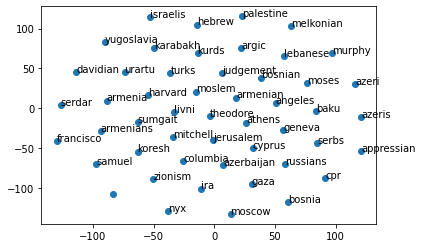

In [ ]:
plt.scatter(tsne_data[:,0],tsne_data[:,1])
for i in range(len(words[:50]) - 1):
    plt.annotate(words[i], xy = (tsne_data[i][0],tsne_data[i][1]))
plt.show()